#### Importing libraries

In [ ]:
import os
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Reading and Preprocessing dataset

In [ ]:
# Define the root directory where your data is stored
data_root = 'D:\\anc\\CV\\HiT_demo_20100820\\dataset'

# Define image size and batch size
img_size = (224, 224)
batch_size = 10

# Create an ImageDataGenerator for data augmentation and normalization
datagen = ImageDataGenerator(
    rescale=1./255,        # Normalize pixel values to be between 0 and 1
    shear_range=0.2,       # Shear Intensity
    zoom_range=0.2,        # Zoom Intensity
    horizontal_flip=True,  # Randomly flip images horizontally
    validation_split=0.2   # Split train and test data
)

# Use flow_from_directory to load images from folders
train_generator = datagen.flow_from_directory(
    data_root,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='training'  # training set
)

# Create a generator for test data
test_generator = datagen.flow_from_directory(
    data_root,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # Use 'validation' for the test set
)

Found 80 images belonging to 4 classes.
Found 19 images belonging to 4 classes.


Class: catHead, Count: 16
Class: monkeyHead, Count: 40
Class: pandaHead, Count: 13
Class: zebra, Count: 11


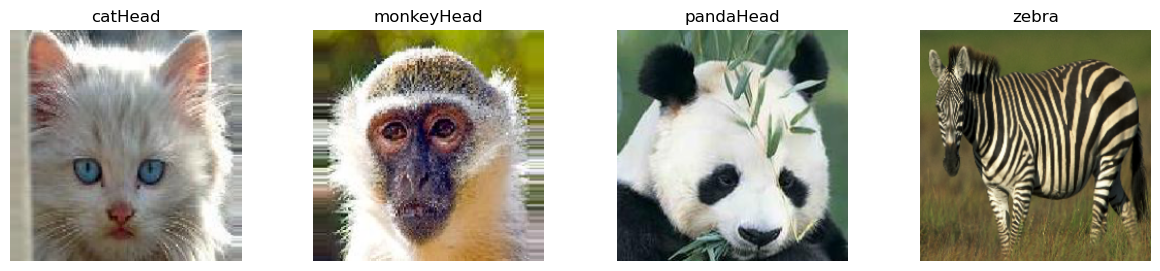

In [ ]:
# Get the class indices from the generator
class_indices = train_generator.class_indices

# Number of classes
num_classes = len(train_generator.class_indices)

# Get the list of class labels
class_labels = list(class_indices.keys())

# Count the number of images for each class
class_counts = {label: sum(train_generator.classes == class_indices[label]) for label in class_labels}

# Initialize a dictionary to store the first image from each class
class_images = {label: None for label in class_labels}

# Display the counts
for label, count in class_counts.items():
    print(f"Class: {label}, Count: {count}")


# Iterate through the generator to find the first image from each class
for images, labels in train_generator:
    for image, label in zip(images, labels):
        class_label = class_labels[np.argmax(label)]
        if class_images[class_label] is None:
            class_images[class_label] = image

    # Check if images from all classes have been found
    if all(image is not None for image in class_images.values()):
        break

# Display the images from each class
fig, axs = plt.subplots(1, len(class_labels), figsize=(15, 3))
for i, (label, image) in enumerate(class_images.items()):
    axs[i].imshow(image)
    axs[i].set_title(f'{label}')
    axs[i].axis('off')
plt.show()

### Building simple CNN model

In [ ]:
# Define the CNN model
model = models.Sequential()

# Convolutional layers
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten layer to transition from convolutional to dense layers
model.add(layers.Flatten())

# Dense (fully connected) layers
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)      

### Fitting the model

In [ ]:
# Train the model using the generator
model.fit(train_generator, epochs=10,verbose=2)
 # Adjust the number of epochs as needed

Epoch 1/10
8/8 - 6s - loss: 2.2769 - accuracy: 0.3000 - 6s/epoch - 709ms/step
Epoch 2/10
8/8 - 4s - loss: 1.1528 - accuracy: 0.5750 - 4s/epoch - 446ms/step
Epoch 3/10
8/8 - 4s - loss: 0.7644 - accuracy: 0.7875 - 4s/epoch - 466ms/step
Epoch 4/10
8/8 - 4s - loss: 0.5082 - accuracy: 0.7625 - 4s/epoch - 487ms/step
Epoch 5/10
8/8 - 4s - loss: 0.3197 - accuracy: 0.9250 - 4s/epoch - 474ms/step
Epoch 6/10
8/8 - 3s - loss: 0.2054 - accuracy: 0.9375 - 3s/epoch - 437ms/step
Epoch 7/10
8/8 - 4s - loss: 0.1782 - accuracy: 0.9250 - 4s/epoch - 450ms/step
Epoch 8/10
8/8 - 4s - loss: 0.4191 - accuracy: 0.9125 - 4s/epoch - 513ms/step
Epoch 9/10
8/8 - 4s - loss: 0.2806 - accuracy: 0.8625 - 4s/epoch - 548ms/step
Epoch 10/10
8/8 - 4s - loss: 0.2437 - accuracy: 0.9250 - 4s/epoch - 471ms/step


### Performance metrics

2/2 [==============================] - 0s 94ms/step
Accuracy: 0.3684210526315789


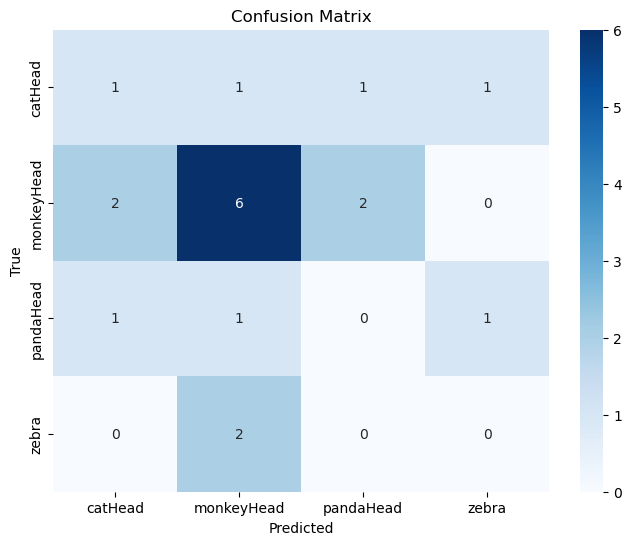

In [ ]:
# Step 1: Make Predictions on the test set
predictions_CNN = model.predict(test_generator)

# Step 2: Post-process Predictions
predicted_labels = np.argmax(predictions_CNN, axis=1)

# Step 3: Get True Labels
true_labels = test_generator.classes

# Step 4: Evaluate Accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

# Step 5: Confusion Matrix
class_labels = list(test_generator.class_indices.keys())
cm = confusion_matrix(true_labels, predicted_labels)

# Display the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

### Using VGG16 model

In [ ]:
# Load the pre-trained VGG16 model without the top classification layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top of the pre-trained base
model2 = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               3211392   
                                                                 
 dense_3 (Dense)             (None, 4)                 516       
                                                                 
Total params: 17926596 (68.38 MB)
Trainable params: 3211908 (12.25 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


### Fitting the model

In [ ]:
# Train the model using the generator
model2.fit(train_generator, epochs=3, verbose=2)

Epoch 1/3
8/8 - 19s - loss: 3.5536 - accuracy: 0.5250 - 19s/epoch - 2s/step
Epoch 2/3
8/8 - 16s - loss: 0.2859 - accuracy: 0.8750 - 16s/epoch - 2s/step
Epoch 3/3
8/8 - 16s - loss: 0.0735 - accuracy: 0.9500 - 16s/epoch - 2s/step


### Performance metrics

2/2 [==============================] - 4s 1s/step
Accuracy: 0.5263157894736842


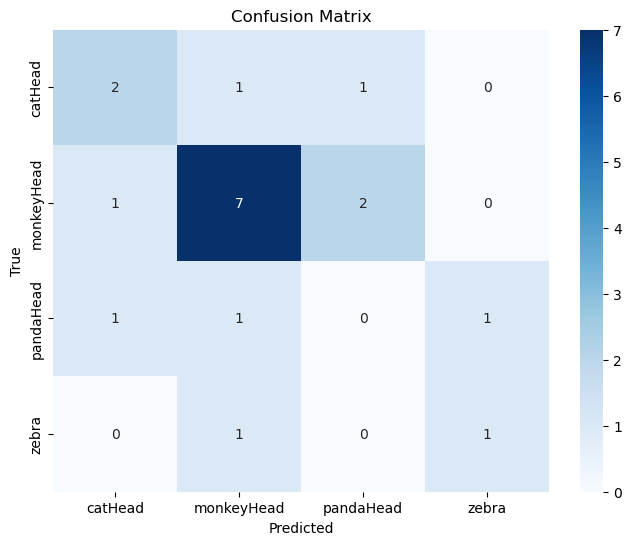

In [ ]:
# Step 1: Make Predictions on the test set
predictions_VGG16 = model2.predict(test_generator)

# Step 2: Post-process Predictions
predicted_labels = np.argmax(predictions_VGG16, axis=1)

# Step 3: Get True Labels
true_labels = test_generator.classes

# Step 4: Evaluate Accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

# Step 5: Confusion Matrix
class_labels = list(test_generator.class_indices.keys())
cm = confusion_matrix(true_labels, predicted_labels)

# Display the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

### Score-Level Fusion

Accuracy: 0.5789473684210527


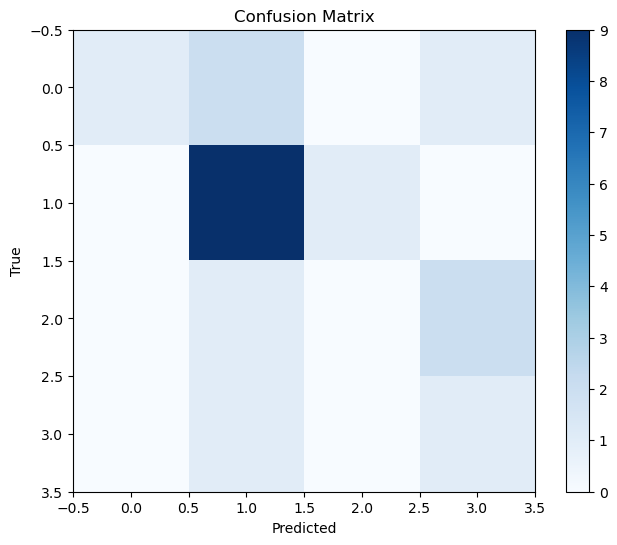

In [ ]:
# Combine the predictions using score-level fusion (weighted averaging)
combined_predictions = 0.5 * (predictions_CNN + predictions_VGG16)

# Convert the combined predictions to class labels
final_predictions = np.argmax(combined_predictions, axis=1)

# Step 6: Evaluate the Model
accuracy = accuracy_score(test_generator.classes, final_predictions)
conf_matrix = confusion_matrix(test_generator.classes, final_predictions)

print("Accuracy:", accuracy)

# Visualize confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()